<a href="https://colab.research.google.com/github/Omri-Naishtein/Spotify-explicit-song-classifier/blob/main/maincode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p dir="rtl"><font size="6"><b>Spotify explicit classification</b></font></p>

in this notebook i've tried to make an AI model that classify a song to either explicit or not explicit without using the songs lyrics. i've used the recall metric because i belive that in our context we want as much explicit songs to be 'cought' and not be missed.


#imports of files and library


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Models

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

# EDA

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# general

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
file_id = 'PRIVATE'
url = "PRIVATE"
path = 'PRIVATE'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438127 entries, 0 to 438126
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_name        438122 non-null  object 
 1   release_date      438104 non-null  object 
 2   artist_id         438127 non-null  object 
 3   track_popularity  438127 non-null  int64  
 4   explicit          438127 non-null  bool   
 5   artist_name       438127 non-null  object 
 6   followers         438127 non-null  int64  
 7   danceability      438127 non-null  float64
 8   energy            438127 non-null  float64
 9   key               438127 non-null  int64  
 10  loudness          438127 non-null  float64
 11  mode              438127 non-null  int64  
 12  speechiness       438127 non-null  float64
 13  acousticness      438127 non-null  float64
 14  instrumentalness  438127 non-null  float64
 15  liveness          438127 non-null  float64
 16  valence           43

<div dir=rtl>

# EDA

in this part ive tried to clean the data as much as I could

In [ ]:
file_id = '1lJZi6o9TBVIKmDwOe9GOYegKinP9wxtn'
url = f"https://drive.google.com/uc?id={file_id}"
path = '/content/drive/MyDrive/מגשימים/שנה ב/שיעור 13 - אבן דרך/קבצי נתונים/EDA_File.csv'
edf = pd.read_csv(path)
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_name        30000 non-null   object 
 1   release_date      149990 non-null  object 
 2   artist_id         150000 non-null  object 
 3   track_popularity  150000 non-null  int64  
 4   explicit          150000 non-null  bool   
 5   artist_name       30000 non-null   object 
 6   danceability      149950 non-null  float64
 7   energy            149990 non-null  float64
 8   key               150000 non-null  int64  
 9   loudness          150000 non-null  float64
 10  mode              150000 non-null  int64  
 11  speechiness       150000 non-null  float64
 12  acousticness      150000 non-null  float64
 13  instrumentalness  150000 non-null  float64
 14  liveness          150000 non-null  float64
 15  valence           150000 non-null  float64
 16  tempo             15

In [ ]:
edf.head(1)

track_name             release_date               artist_id  \
0    Maxwell  2021-10-29 00:00:00 UTC  2ujwZjoQq7iaEFiUWuoRrN   

   track_popularity  explicit artist_name  danceability  energy  key  \
0                 1     False  The Assets         0.624   -8.33    7   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -4.165     1        0.034        0.0952          0.000007       0.1   

   valence    tempo            type  duration_ms num_beats  
0    0.776  120.006  audio_features       285219         4

In [ ]:
edf.duplicated().sum()

102

In [ ]:
edf = edf.drop_duplicates()

In [ ]:
edf.duplicated().sum()

0

In [ ]:
edf = edf.drop(columns = ["track_name", "artist_name"])

In [ ]:
df.columns

Index(['track_name', 'release_date', 'artist_id', 'track_popularity',
       'explicit', 'artist_name', 'followers', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'duration_ms', 'num_beats'],
      dtype='object')

In [ ]:
df["type"].unique()

array(['audio_features'], dtype=object)

In [ ]:
edf = edf.drop(columns=["type"])

In [ ]:
edf = edf.dropna(subset=["release_date"])
edf["release_date"] = edf["release_date"].astype(str).str[:3] + "0"
edf["release_date"] = edf["release_date"].astype(int)
edf = edf.rename(columns={"release_date": "year"})
edf

<ipython-input-7-a41752b819b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf["release_date"] = edf["release_date"].astype(str).str[:3] + "0"
<ipython-input-7-a41752b819b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf["release_date"] = edf["release_date"].astype(int)


year               artist_id  track_popularity  explicit  \
0       2020  2ujwZjoQq7iaEFiUWuoRrN                 1     False   
1       2020  5oLfGRxGbZs7A1oLri3LP9                 0      True   
2       2010  5aTdwObrbHvEhcTorgXZ8o                 0     False   
3       2020  5BwsX8bXOFC1YnqSlyfOKM                50      True   
4       2010  4TsHKU8l8Wq7n7OPVikirn                29      True   
...      ...                     ...               ...       ...   
149995  1990  0d2A861NEFqVpEogrYewVJ                25     False   
149996  2010  5lYcr7Yue9FUB7MJDBtTJx                10     False   
149997  2000  4TMHGUX5WI7OOm53PqSDAT                14     False   
149998  2020  06HL4z0CvFAxyc27GXpf02                61      True   
149999  2020  4HK4FOF99boN9AaOtLdkMb                22     False   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
0              0.624  -8.330    7    -4.165     1       0.0340        0.0952   
1              0.673 -16.048    5    -8.024     1       0.3010        0.0986   
2              0.755 -18.198   10    -9.099     0       0.0278        0.7330   
3              0.650  -9.476    8    -4.738     0       0.1630        0.0166   
4              0.818  -9.132    7    -4.566     0       0.0552        0.0460   
...              ...     ...  ...       ...   ...          ...           ...   
149995         0.777 -23.668   11   -11.834     1       0.2970        0.0513   
149996         0.389 -22.326    7   -11.163     1       0.0652        0.0755   
149997         0.683   0.440    9   -15.065     1       0.0342        0.8570   
149998         0.781 -13.650   10    -6.825     1       0.1690        0.0297   
149999         0.772 -11.328   10    -5.664     1       0.0609        0.0534   

        instrumentalness  liveness  valence    tempo  duration_ms num_beats  
0               0.000007    0.1000    0.776  120.006       285219         4  
1               0.000001    0.3380    0.338   83.090       147470         4  
2               0.015600    0.2170    0.692   96.738       411413         1  
3               0.000000    0.0979    0.641  129.885       158769         4  
4               0.000000    0.2050    0.624   97.916       247779         4  
...                  ...       ...      ...      ...          ...       ...  
149995          0.000000    0.0404    0.968  135.126       242133         4  
149996          0.887000    0.1350    0.521  140.804       264253         4  
149997          0.023000    0.3250    0.684  116.731       390227         4  
149998          0.002800    0.2730    0.629  119.972       171562         4  
149999          0.000002    0.1210    0.880   90.055       172960         4  

[149888 rows x 17 columns]

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in edf.columns:
  if edf[i].dtype == "object":
    edf[i] = le.fit_transform(edf[i])

edf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149888 entries, 0 to 149999
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              149888 non-null  int64  
 1   artist_id         149888 non-null  int64  
 2   track_popularity  149888 non-null  int64  
 3   explicit          149888 non-null  bool   
 4   danceability      149838 non-null  float64
 5   energy            149878 non-null  float64
 6   key               149888 non-null  int64  
 7   loudness          149888 non-null  float64
 8   mode              149888 non-null  int64  
 9   speechiness       149888 non-null  float64
 10  acousticness      149888 non-null  float64
 11  instrumentalness  149888 non-null  float64
 12  liveness          149888 non-null  float64
 13  valence           149888 non-null  float64
 14  tempo             149888 non-null  float64
 15  duration_ms       149888 non-null  int64  
 16  num_beats         149888 

In [ ]:
for i in edf.columns:
  print(f"{i} min value: {edf[i].min()}, max value: {edf[i].max()} ")

year min value: 1880, max value: 2020 
artist_id min value: 0, max value: 23388 
track_popularity min value: 0, max value: 99 
explicit min value: False, max value: True 
danceability min value: 0.0, max value: 0.993 
energy min value: -120.0, max value: 7.488 
key min value: 0, max value: 3000 
loudness min value: -60.0, max value: 3.744 
mode min value: 0, max value: 1 
speechiness min value: 0.0, max value: 0.97 
acousticness min value: 0.0, max value: 0.996 
instrumentalness min value: 0.0, max value: 1.0 
liveness min value: 0.0, max value: 1.0 
valence min value: 0.0, max value: 1.0 
tempo min value: 0.0, max value: 1495.0 
duration_ms min value: 1719, max value: 5280027 
num_beats min value: 0, max value: 4 


In [ ]:
edf[edf["energy"] < 0].count().iloc[0]

139823

<Axes: xlabel='energy', ylabel='Count'>

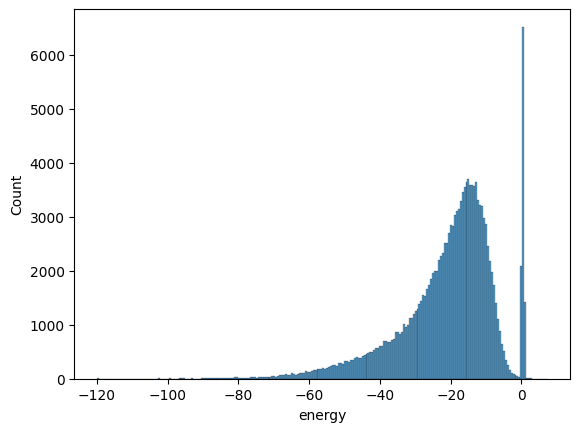

In [ ]:
sns.histplot(x= edf["energy"])

In [ ]:
edf[edf["loudness"] < 0].count().iloc[0]

149813

<Axes: xlabel='loudness', ylabel='Count'>

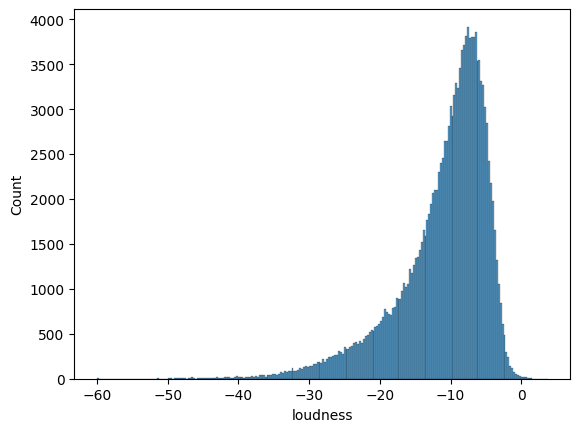

In [ ]:
sns.histplot(x= edf["loudness"])

In [ ]:
edf = edf.dropna()
print(edf.shape)
edf.info()

(149828, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 149828 entries, 0 to 149999
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              149828 non-null  int64  
 1   artist_id         149828 non-null  int64  
 2   track_popularity  149828 non-null  int64  
 3   explicit          149828 non-null  bool   
 4   danceability      149828 non-null  float64
 5   energy            149828 non-null  float64
 6   key               149828 non-null  int64  
 7   loudness          149828 non-null  float64
 8   mode              149828 non-null  int64  
 9   speechiness       149828 non-null  float64
 10  acousticness      149828 non-null  float64
 11  instrumentalness  149828 non-null  float64
 12  liveness          149828 non-null  float64
 13  valence           149828 non-null  float64
 14  tempo             149828 non-null  float64
 15  duration_ms       149828 non-null  int64  
 16  num_beats   

In [ ]:
X = edf.drop(columns = "explicit")
y = edf["explicit"]

<div dir=rtl>

##running models after cleaning

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

kf = KFold(n_splits=5, random_state=8, shuffle=True)
scoring_method = "accuracy", "recall", "precision"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 8)

In [ ]:
#knn
knn = KNeighborsClassifier(n_neighbors=5)

cv_results = cross_validate(estimator = knn, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  0.079907   18.021183       0.829058     0.078867        0.266667
1  0.024104   17.406271       0.833187     0.087293        0.273543
2  0.023062   17.685342       0.835183     0.086455        0.277521
3  0.023510   18.422176       0.829718     0.073300        0.257843
4  0.022651   17.579462       0.830010     0.080347        0.266481

In [ ]:
tr = DecisionTreeClassifier(random_state=42)

cv_results = cross_validate(estimator = tr, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  3.448828    0.040794       0.863930     0.556512        0.546198
1  3.008107    0.028173       0.866308     0.568689        0.539213
2  3.659483    0.026329       0.864759     0.548127        0.531879
3  2.632135    0.026734       0.863257     0.557414        0.542005
4  2.595895    0.037188       0.863257     0.537234        0.541479

<div dir=rtl>

##correlation check

in this part I've checked the correlation and removed outliers

In [ ]:
def iqr_remove(X,y,column):
  q1 = X[column].quantile(0.25)
  q3 = X[column].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr)

  indices_to_drop = (X[column] < lower_bound) | (X[column] > upper_bound)
  X.drop(X[indices_to_drop].index, inplace=True)
  y.drop(y[indices_to_drop].index, inplace=True)

In [ ]:
X['danceability'].describe()

count    149828.000000
mean          0.574030
std           0.190017
min           0.000000
25%           0.456000
50%           0.600000
75%           0.715000
max           0.993000
Name: danceability, dtype: float64

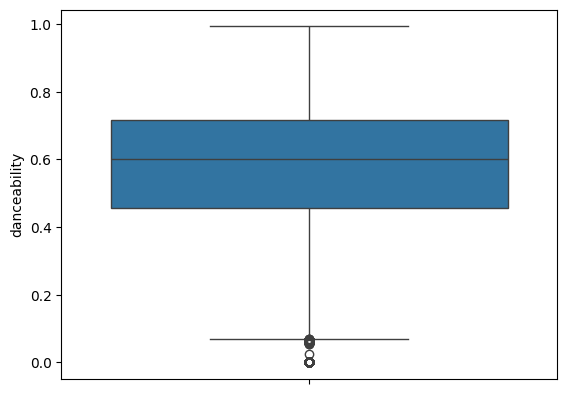

In [ ]:
sns.boxplot(X['danceability'])
plt.show()

<ipython-input-12-17031bd126b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(y[indices_to_drop].index, inplace=True)


<Axes: ylabel='danceability'>

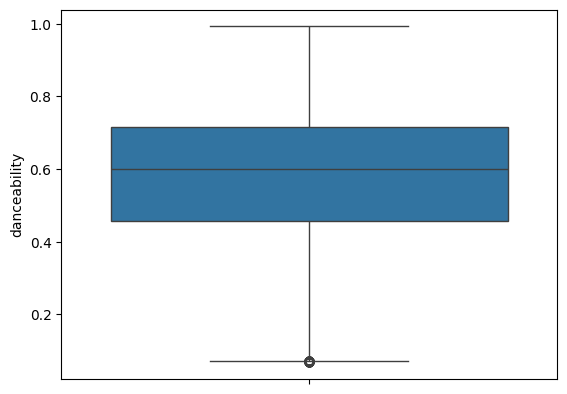

In [ ]:
iqr_remove(X, y, 'danceability')
sns.boxplot(X['danceability'])

<Axes: xlabel='danceability', ylabel='Count'>

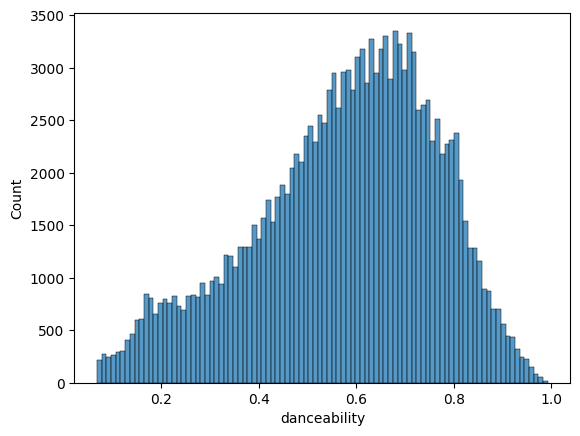

In [ ]:
sns.histplot(X['danceability'])

In [ ]:
# מאחר והפיצ'ר מתפלג נורמלית נשתמש בשיטת ה- StandardScaler
scaler = StandardScaler()
X['danceability'] = scaler.fit_transform(X[['danceability']])

 <p dir="rtl"> פתרון שלב 2:</p>

In [ ]:
X.head(1)

year  artist_id  track_popularity  danceability  energy  key  loudness  \
0  2020       8812                 1      0.256636   -8.33    7    -4.165   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1        0.034        0.0952          0.000007       0.1    0.776   

     tempo  duration_ms  num_beats  
0  120.006       285219          2

149336


<Axes: xlabel='key'>

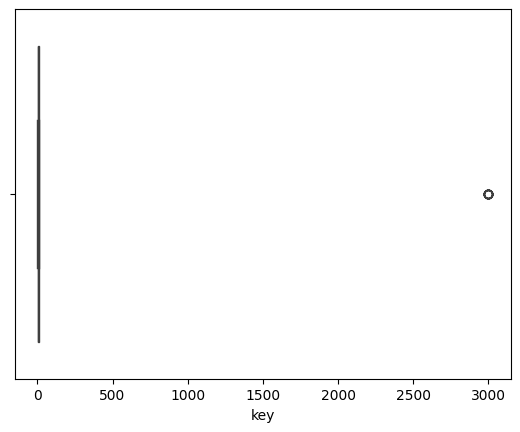

In [ ]:
print(X.count().iloc[0])
sns.boxplot(x = X["key"])

<ipython-input-12-17031bd126b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(y[indices_to_drop].index, inplace=True)


<Axes: xlabel='key'>

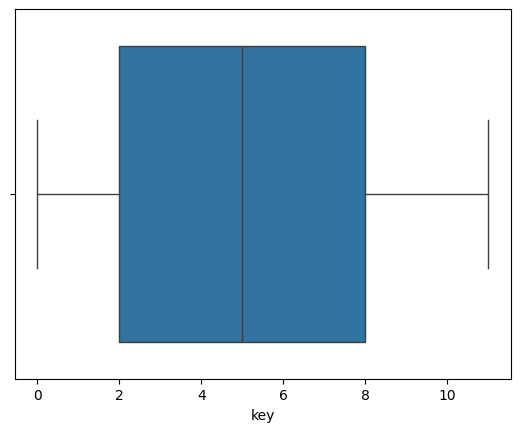

In [ ]:
iqr_remove(X, y, 'key')
sns.boxplot(x = X["key"])

149317


<Axes: xlabel='key', ylabel='Count'>

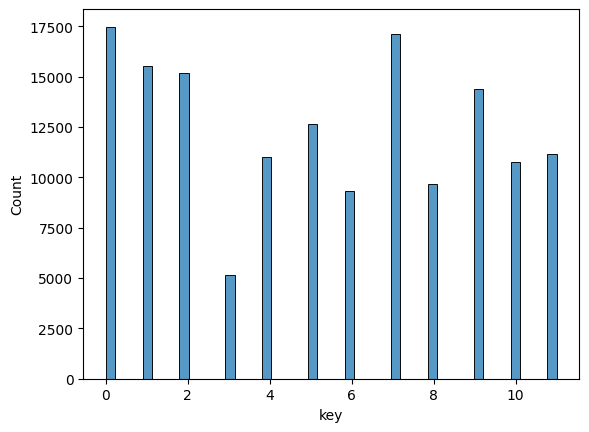

In [ ]:
print(X.count().iloc[0])
sns.histplot(X['key'])

In [ ]:
X.head(1)

year  artist_id  track_popularity  danceability  energy  key  loudness  \
0  2020       8812                 1      0.256636   -8.33    7    -4.165   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1        0.034        0.0952          0.000007       0.1    0.776   

     tempo  duration_ms  num_beats  
0  120.006       285219          2

<Axes: xlabel='key', ylabel='Count'>

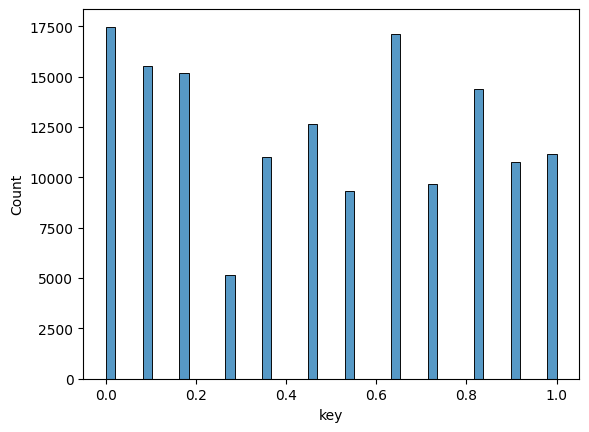

In [ ]:
mms = MinMaxScaler()

X["key"] = mms.fit_transform(X[["key"]])
sns.histplot(X["key"])

<Axes: xlabel='tempo'>

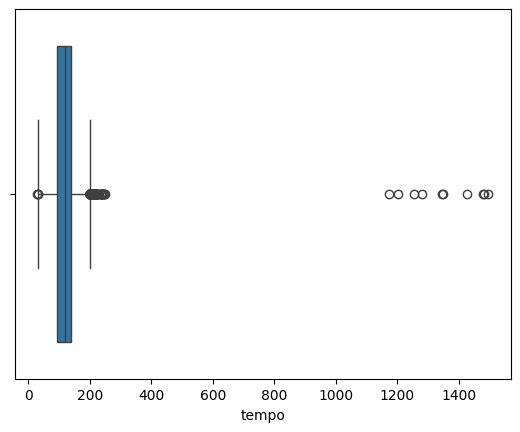

In [ ]:
sns.boxplot(x = X["tempo"])

<ipython-input-12-17031bd126b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(y[indices_to_drop].index, inplace=True)


<Axes: xlabel='tempo'>

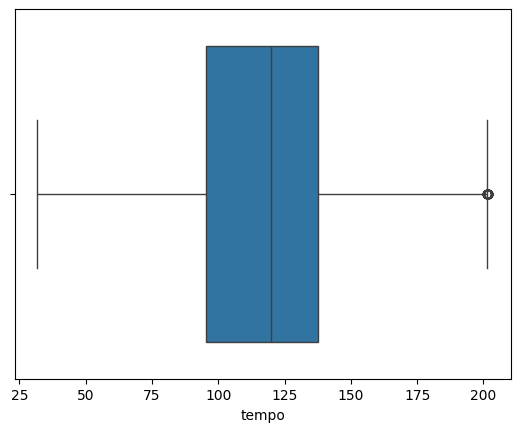

In [ ]:
iqr_remove(X, y, 'tempo')
sns.boxplot(x = X["tempo"])

In [ ]:
print(X.count().iloc[0])

148678


<Axes: xlabel='tempo', ylabel='Count'>

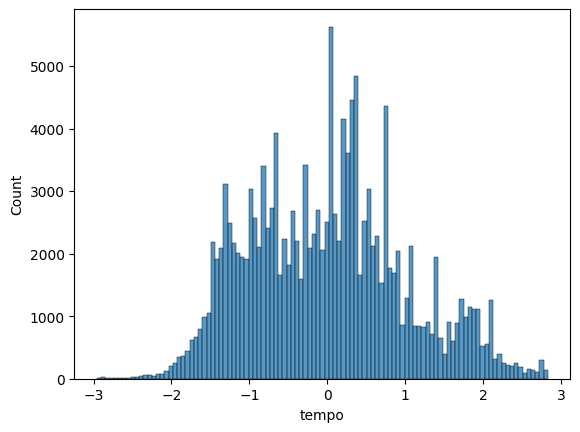

In [ ]:
X['tempo'] = scaler.fit_transform(X[['tempo']])
sns.histplot(X['tempo'])

<Axes: xlabel='duration_ms'>

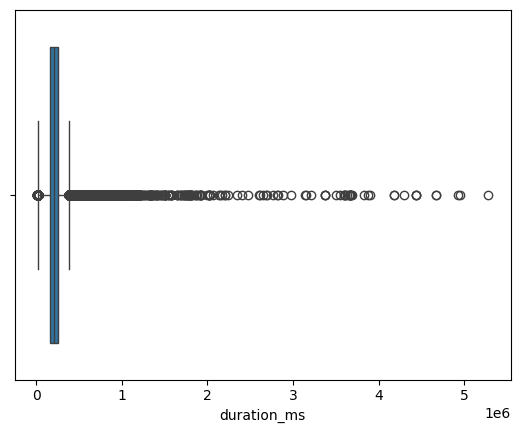

In [ ]:
sns.boxplot(x = X["duration_ms"])

<ipython-input-12-17031bd126b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(y[indices_to_drop].index, inplace=True)


<Axes: xlabel='duration_ms'>

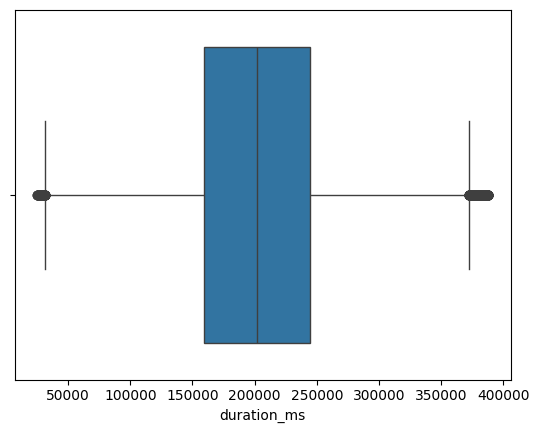

In [ ]:
iqr_remove(X, y, 'duration_ms')
sns.boxplot(x = X["duration_ms"])

141992


<Axes: xlabel='duration_ms', ylabel='Count'>

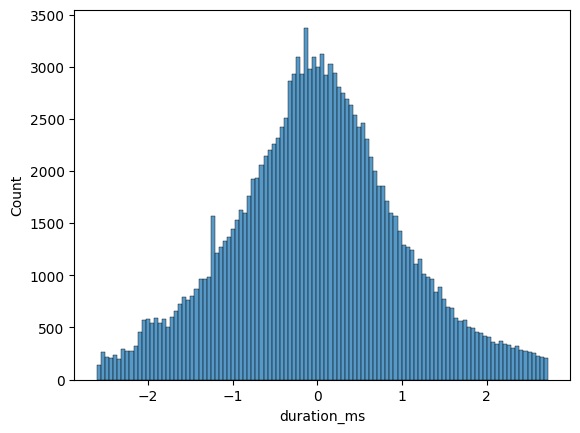

In [ ]:
print(X.count().iloc[0])
X['duration_ms'] = scaler.fit_transform(X[['duration_ms']])
sns.histplot(X['duration_ms'])

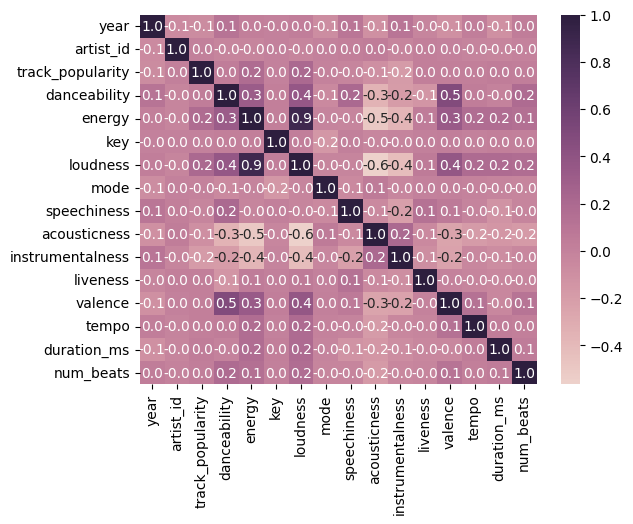

In [ ]:
ht = X.corr()
sns.heatmap(ht, annot=True, fmt=".1f", cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

<div dir=rtl>

##running models again

In [ ]:
kf = KFold(n_splits=5, random_state=8, shuffle=True)
scoring_method = "accuracy", "recall", "precision"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 8)

In [ ]:
#knn
knn = KNeighborsClassifier(n_neighbors=5)

cv_results = cross_validate(estimator = knn, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  0.041388   16.178874       0.886307     0.524359        0.660974
1  0.025315   16.024047       0.887099     0.549407        0.667581
2  0.039863   16.237182       0.887891     0.526225        0.672527
3  0.023268   16.064512       0.889603     0.538838        0.674226
4  0.023884   15.996902       0.886918     0.525424        0.655487

In [ ]:
#decision tree
tr = DecisionTreeClassifier(random_state=42)

cv_results = cross_validate(estimator = tr, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  2.369355    0.025523       0.860997     0.558662        0.543619
1  2.383933    0.026324       0.859633     0.553924        0.549426
2  3.235611    0.038358       0.860557     0.545715        0.546028
3  2.862710    0.025350       0.861255     0.552071        0.546101
4  2.404343    0.025054       0.859495     0.564874        0.531628

<div dir=rtl>

##scaling and outliers removal - continue

In [ ]:
X

year  artist_id  track_popularity  danceability  energy       key  \
0       2020       8812                 1      0.256636  -8.330  0.636364   
1       2020      17520                 0      0.517625 -16.048  0.454545   
3       2020      15590                50      0.395120  -9.476  0.727273   
4       2010      13394                29      1.289941  -9.132  0.636364   
5       2020      17643                 5      0.230004 -18.602  1.000000   
...      ...        ...               ...           ...     ...       ...   
149994  2010       1119                 0     -1.357238 -40.802  0.818182   
149995  1990       1960                25      1.071562 -23.668  1.000000   
149996  2010      17375                10     -0.995049 -22.326  0.636364   
149998  2020        344                61      1.092867 -13.650  0.909091   
149999  2020      12813                22      1.044931 -11.328  0.909091   

        loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0         -4.165     1       0.0340        0.0952          0.000007    0.1000   
1         -8.024     1       0.3010        0.0986          0.000001    0.3380   
3         -4.738     0       0.1630        0.0166          0.000000    0.0979   
4         -4.566     0       0.0552        0.0460          0.000000    0.2050   
5         -9.301     0       0.0274        0.5750          0.295000    0.1110   
...          ...   ...          ...           ...               ...       ...   
149994   -20.401     1       0.0356        0.5210          0.818000    0.0956   
149995   -11.834     1       0.2970        0.0513          0.000000    0.0404   
149996   -11.163     1       0.0652        0.0755          0.887000    0.1350   
149998    -6.825     1       0.1690        0.0297          0.002800    0.2730   
149999    -5.664     1       0.0609        0.0534          0.000002    0.1210   

        valence     tempo  duration_ms  num_beats  
0         0.776  0.044949     1.215227          2  
1         0.338 -1.210764    -0.807343          2  
3         0.641  0.380987    -0.641439          2  
4         0.624 -0.706451     0.665495          2  
5         0.591  0.045289    -1.269417          2  
...         ...       ...          ...        ...  
149994    0.131  0.484972     1.141533          2  
149995    0.968  0.559262     0.582595          2  
149996    0.521  0.752401     0.907383          2  
149998    0.629  0.043793    -0.453600          2  
149999    0.880 -0.973846    -0.433073          2  

[141992 rows x 16 columns]

<Axes: xlabel='year'>

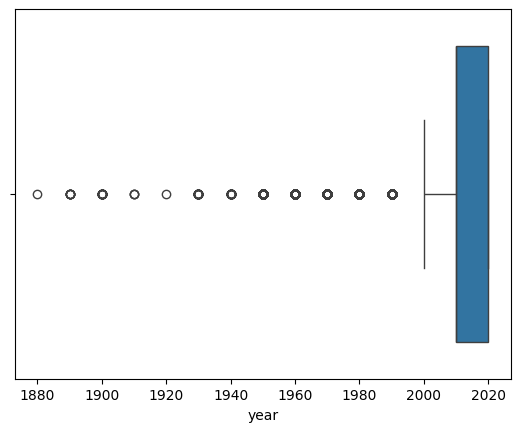

In [ ]:
sns.boxplot(x = X["year"])

In [ ]:
X.groupby(by=["year"]).agg({"year": "sum"})

year
year           
1880       1880
1890      13230
1900      47500
1910       5730
1920       1920
1930      55970
1940      56260
1950     945750
1960    2653840
1970    3636620
1980    4813380
1990   13382750
2000   37434000
2010  113173050
2020  109148680

In [ ]:
X = X[X["year"] > 1940]

In [ ]:
X.groupby(by=["year"]).agg({"year": "sum"})

year
year           
1950     945750
1960    2653840
1970    3636620
1980    4813380
1990   13382750
2000   37434000
2010  113173050
2020  109148680

<Axes: xlabel='track_popularity'>

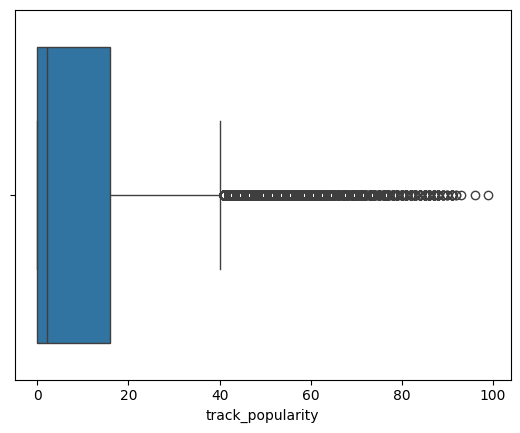

In [ ]:
sns.boxplot(x = X["track_popularity"])

In [ ]:
X = X.drop(["track_popularity"], axis=1)
X

year  artist_id  danceability  energy       key  loudness  mode  \
0       2020       8812      0.256636  -8.330  0.636364    -4.165     1   
1       2020      17520      0.517625 -16.048  0.454545    -8.024     1   
3       2020      15590      0.395120  -9.476  0.727273    -4.738     0   
4       2010      13394      1.289941  -9.132  0.636364    -4.566     0   
5       2020      17643      0.230004 -18.602  1.000000    -9.301     0   
...      ...        ...           ...     ...       ...       ...   ...   
149994  2010       1119     -1.357238 -40.802  0.818182   -20.401     1   
149995  1990       1960      1.071562 -23.668  1.000000   -11.834     1   
149996  2010      17375     -0.995049 -22.326  0.636364   -11.163     1   
149998  2020        344      1.092867 -13.650  0.909091    -6.825     1   
149999  2020      12813      1.044931 -11.328  0.909091    -5.664     1   

        speechiness  acousticness  instrumentalness  liveness  valence  \
0            0.0340        0.0952          0.000007    0.1000    0.776   
1            0.3010        0.0986          0.000001    0.3380    0.338   
3            0.1630        0.0166          0.000000    0.0979    0.641   
4            0.0552        0.0460          0.000000    0.2050    0.624   
5            0.0274        0.5750          0.295000    0.1110    0.591   
...             ...           ...               ...       ...      ...   
149994       0.0356        0.5210          0.818000    0.0956    0.131   
149995       0.2970        0.0513          0.000000    0.0404    0.968   
149996       0.0652        0.0755          0.887000    0.1350    0.521   
149998       0.1690        0.0297          0.002800    0.2730    0.629   
149999       0.0609        0.0534          0.000002    0.1210    0.880   

           tempo  duration_ms  num_beats  
0       0.044949     1.215227          2  
1      -1.210764    -0.807343          2  
3       0.380987    -0.641439          2  
4      -0.706451     0.665495          2  
5       0.045289    -1.269417          2  
...          ...          ...        ...  
149994  0.484972     1.141533          2  
149995  0.559262     0.582595          2  
149996  0.752401     0.907383          2  
149998  0.043793    -0.453600          2  
149999 -0.973846    -0.433073          2  

[141897 rows x 15 columns]

<Axes: xlabel='danceability'>

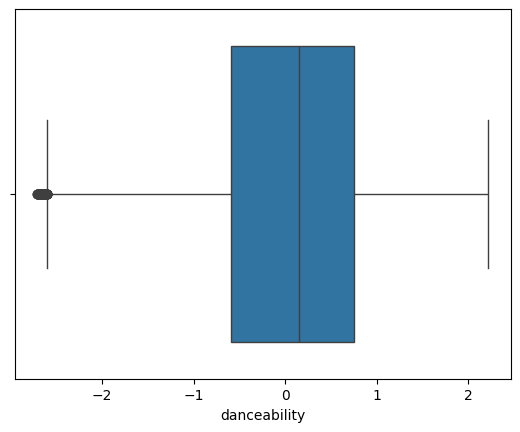

In [ ]:
sns.boxplot(x = X["danceability"])

<Axes: xlabel='mode', ylabel='count'>

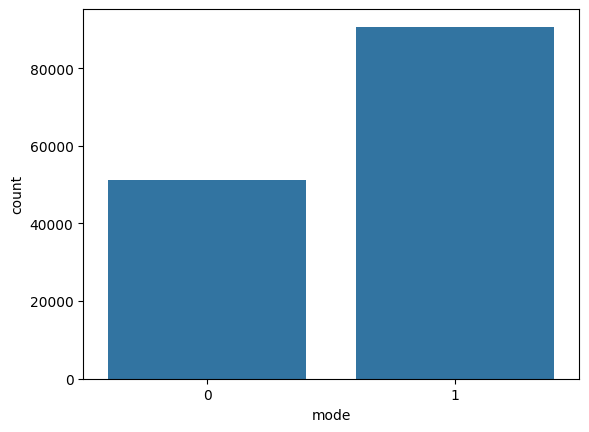

In [ ]:
sns.countplot(x = X["mode"])

In [ ]:
X = X.drop(["mode", "energy"], axis=1)
X

year  artist_id  danceability       key  loudness  speechiness  \
0       2020       8812      0.256636  0.636364    -4.165       0.0340   
1       2020      17520      0.517625  0.454545    -8.024       0.3010   
3       2020      15590      0.395120  0.727273    -4.738       0.1630   
4       2010      13394      1.289941  0.636364    -4.566       0.0552   
5       2020      17643      0.230004  1.000000    -9.301       0.0274   
...      ...        ...           ...       ...       ...          ...   
149994  2010       1119     -1.357238  0.818182   -20.401       0.0356   
149995  1990       1960      1.071562  1.000000   -11.834       0.2970   
149996  2010      17375     -0.995049  0.636364   -11.163       0.0652   
149998  2020        344      1.092867  0.909091    -6.825       0.1690   
149999  2020      12813      1.044931  0.909091    -5.664       0.0609   

        acousticness  instrumentalness  liveness  valence     tempo  \
0             0.0952          0.000007    0.1000    0.776  0.044949   
1             0.0986          0.000001    0.3380    0.338 -1.210764   
3             0.0166          0.000000    0.0979    0.641  0.380987   
4             0.0460          0.000000    0.2050    0.624 -0.706451   
5             0.5750          0.295000    0.1110    0.591  0.045289   
...              ...               ...       ...      ...       ...   
149994        0.5210          0.818000    0.0956    0.131  0.484972   
149995        0.0513          0.000000    0.0404    0.968  0.559262   
149996        0.0755          0.887000    0.1350    0.521  0.752401   
149998        0.0297          0.002800    0.2730    0.629  0.043793   
149999        0.0534          0.000002    0.1210    0.880 -0.973846   

        duration_ms  num_beats  
0          1.215227          2  
1         -0.807343          2  
3         -0.641439          2  
4          0.665495          2  
5         -1.269417          2  
...             ...        ...  
149994     1.141533          2  
149995     0.582595          2  
149996     0.907383          2  
149998    -0.453600          2  
149999    -0.433073          2  

[141897 rows x 13 columns]

<Axes: xlabel='loudness'>

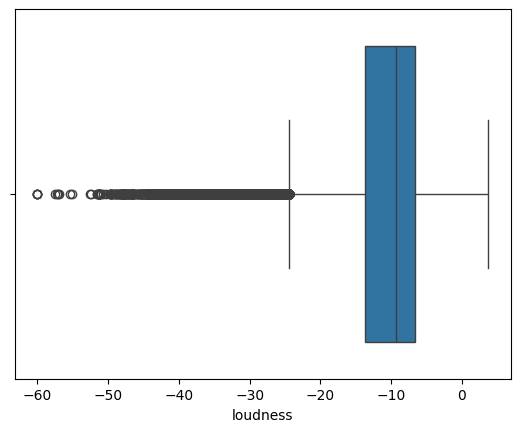

In [ ]:
sns.boxplot(x = X["loudness"])

<Axes: xlabel='speechiness'>

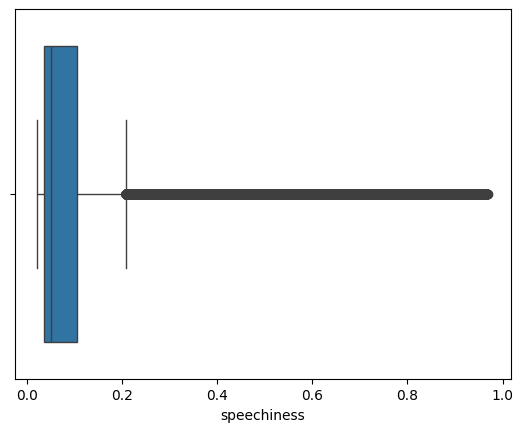

In [ ]:
sns.boxplot(x = X["speechiness"])

<Axes: xlabel='acousticness'>

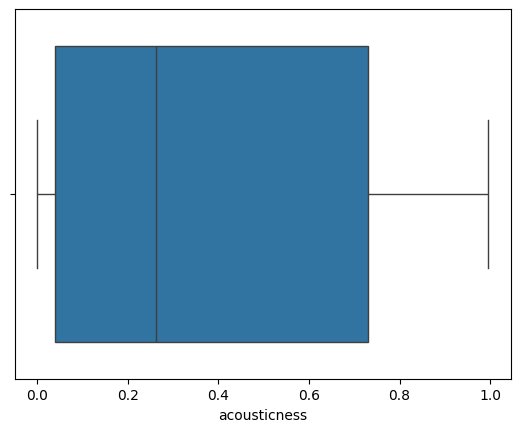

In [ ]:
sns.boxplot(x = X["acousticness"])

<Axes: xlabel='instrumentalness'>

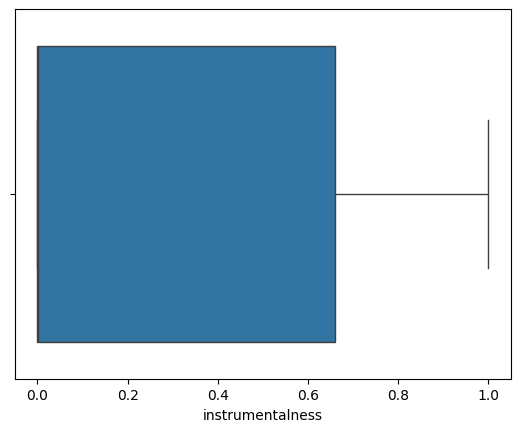

In [ ]:
sns.boxplot(x = X["instrumentalness"])

<Axes: xlabel='liveness'>

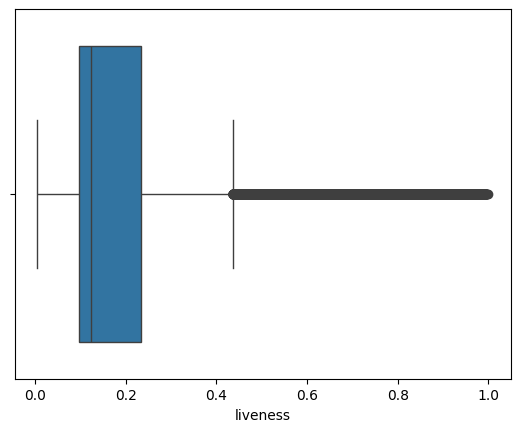

In [ ]:
sns.boxplot(x = X["liveness"])

<Axes: xlabel='valence'>

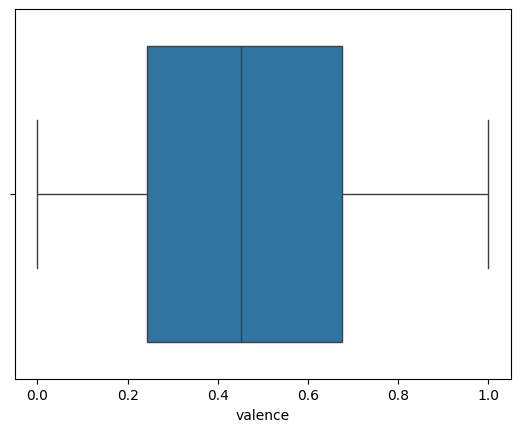

In [ ]:
sns.boxplot(x = X["valence"])

<Axes: xlabel='num_beats', ylabel='Count'>

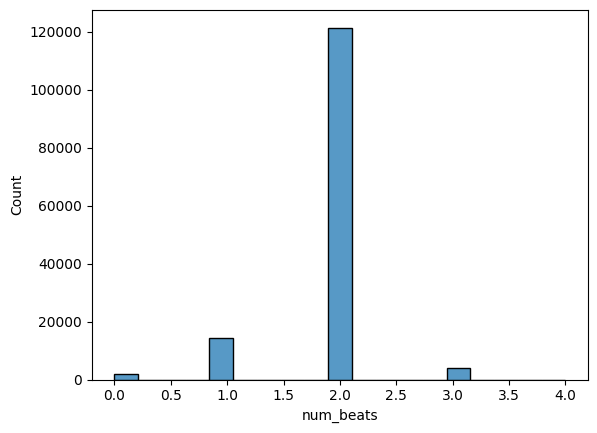

In [ ]:
sns.histplot(x = X["num_beats"])

In [ ]:
X

year  artist_id  danceability       key  loudness  speechiness  \
0       2020       8812      0.256636  0.636364    -4.165       0.0340   
1       2020      17520      0.517625  0.454545    -8.024       0.3010   
3       2020      15590      0.395120  0.727273    -4.738       0.1630   
4       2010      13394      1.289941  0.636364    -4.566       0.0552   
5       2020      17643      0.230004  1.000000    -9.301       0.0274   
...      ...        ...           ...       ...       ...          ...   
149994  2010       1119     -1.357238  0.818182   -20.401       0.0356   
149995  1990       1960      1.071562  1.000000   -11.834       0.2970   
149996  2010      17375     -0.995049  0.636364   -11.163       0.0652   
149998  2020        344      1.092867  0.909091    -6.825       0.1690   
149999  2020      12813      1.044931  0.909091    -5.664       0.0609   

        acousticness  instrumentalness  liveness  valence     tempo  \
0             0.0952          0.000007    0.1000    0.776  0.044949   
1             0.0986          0.000001    0.3380    0.338 -1.210764   
3             0.0166          0.000000    0.0979    0.641  0.380987   
4             0.0460          0.000000    0.2050    0.624 -0.706451   
5             0.5750          0.295000    0.1110    0.591  0.045289   
...              ...               ...       ...      ...       ...   
149994        0.5210          0.818000    0.0956    0.131  0.484972   
149995        0.0513          0.000000    0.0404    0.968  0.559262   
149996        0.0755          0.887000    0.1350    0.521  0.752401   
149998        0.0297          0.002800    0.2730    0.629  0.043793   
149999        0.0534          0.000002    0.1210    0.880 -0.973846   

        duration_ms  num_beats  
0          1.215227          2  
1         -0.807343          2  
3         -0.641439          2  
4          0.665495          2  
5         -1.269417          2  
...             ...        ...  
149994     1.141533          2  
149995     0.582595          2  
149996     0.907383          2  
149998    -0.453600          2  
149999    -0.433073          2  

[141897 rows x 13 columns]

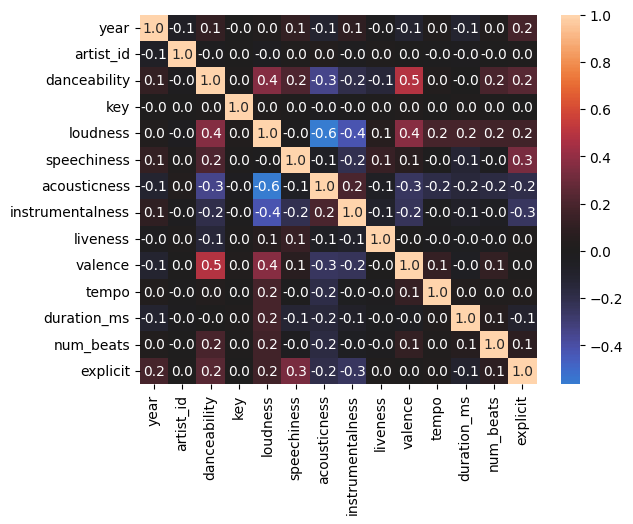

In [ ]:
edf = X.copy()
edf["explicit"] = y
edf.dropna()

X, y = edf.drop(columns = "explicit"), edf["explicit"]

ht = edf.corr()
sns.heatmap(ht, annot=True, fmt=".1f", center=0)
plt.show()

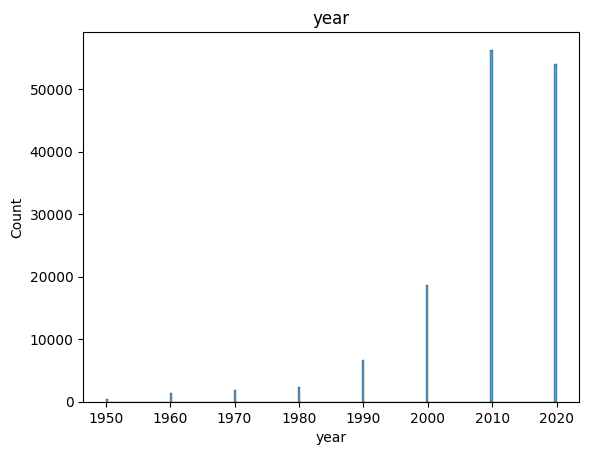

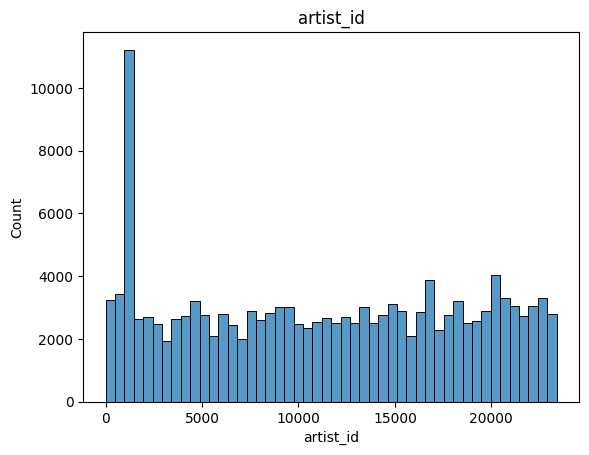

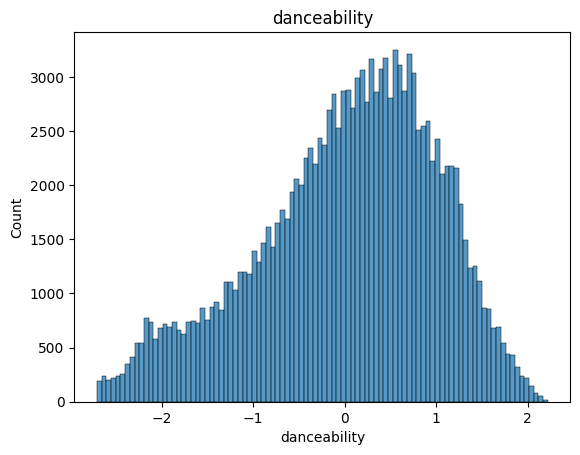

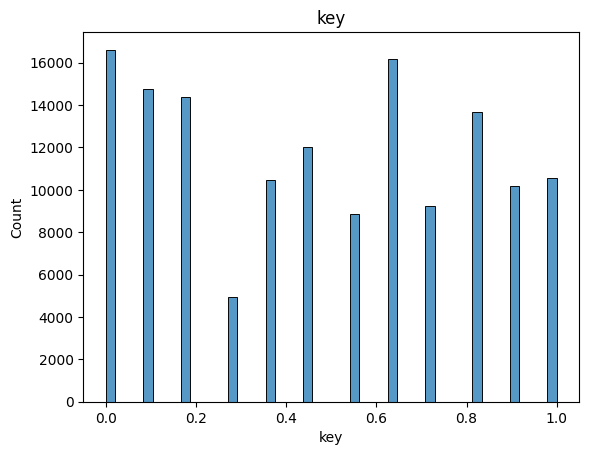

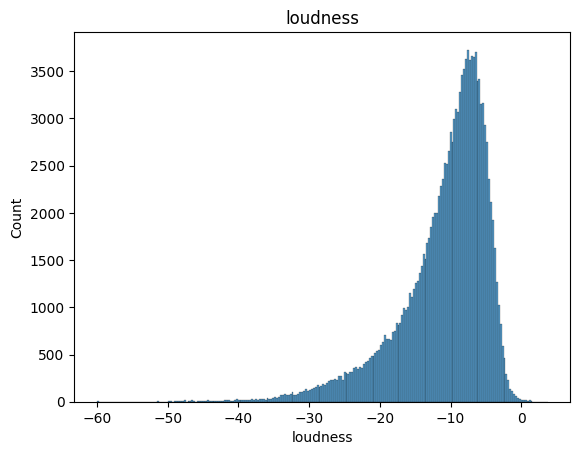

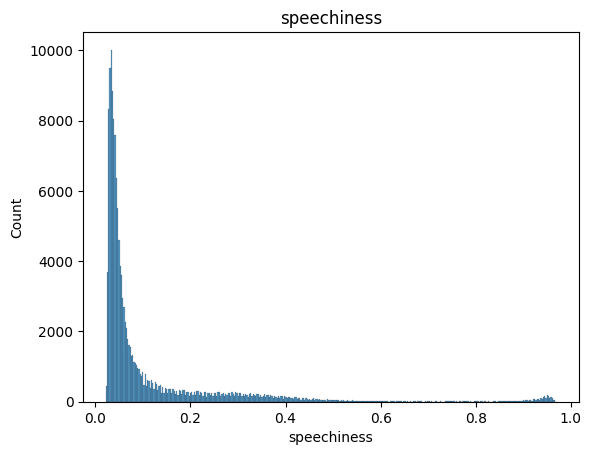

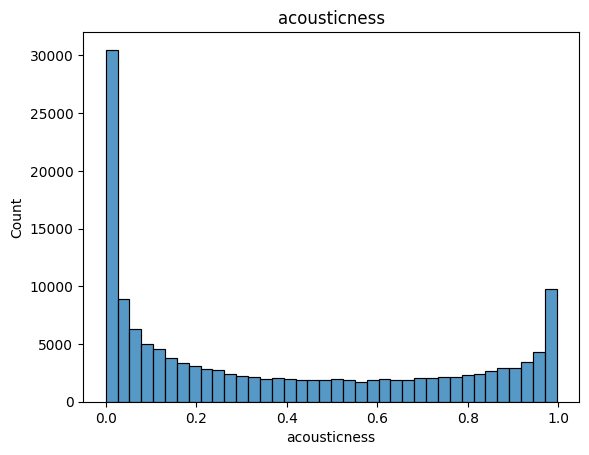

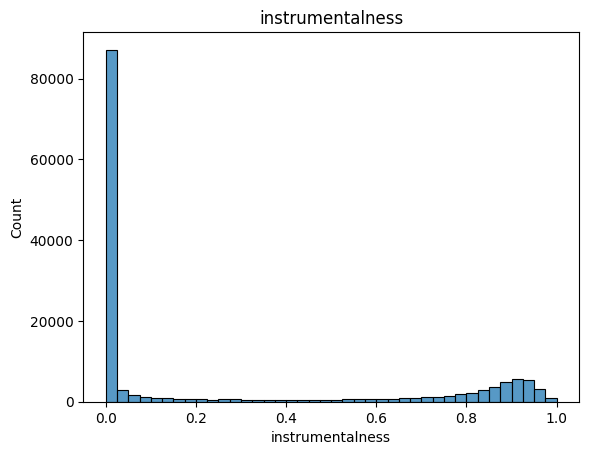

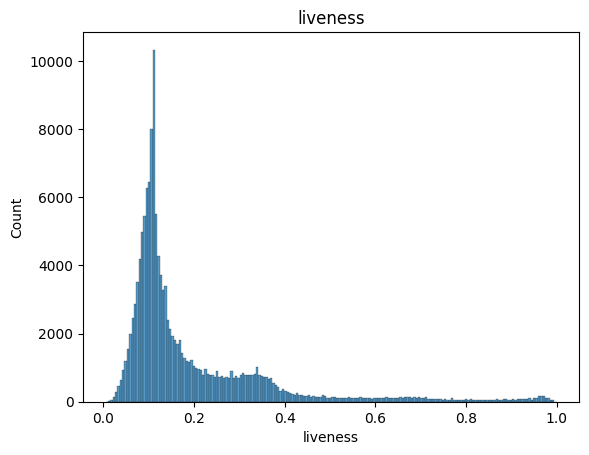

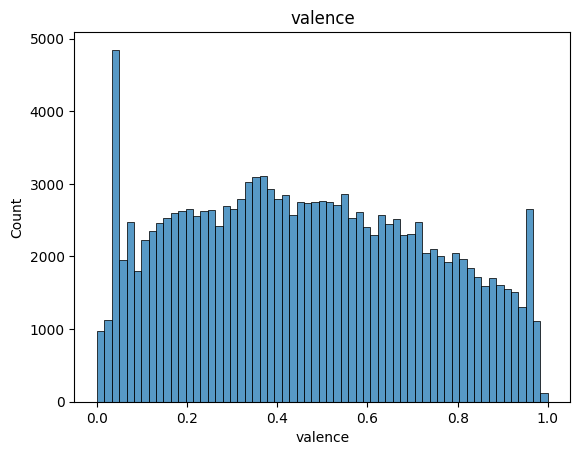

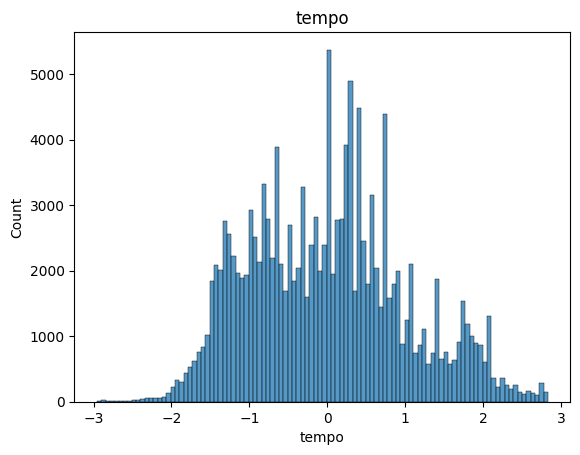

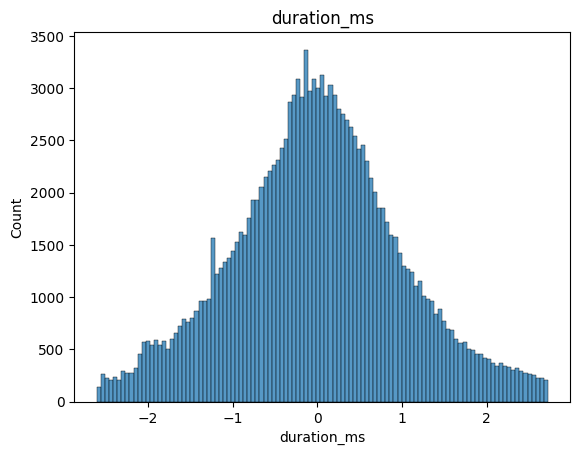

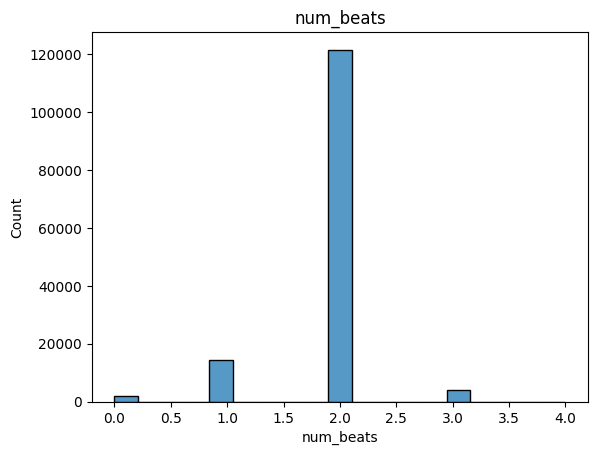

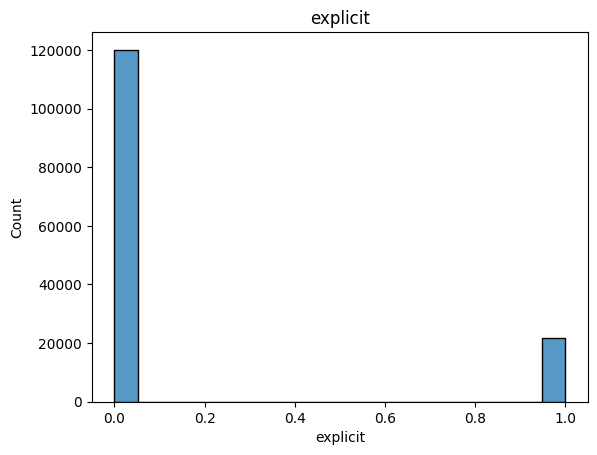

In [ ]:
for i in edf.columns:
  plt.figure()
  sns.histplot(x = edf[i])
  plt.title(i)
  plt.show()

In [ ]:
mms = MinMaxScaler()
for i in X.drop(columns = ["key", "tempo", "duration_ms", "num_beats"]).columns:
  edf[i] = mms.fit_transform(X[[i]])

edf.head()

year  artist_id  danceability       key  loudness  speechiness  \
0  1.000000   0.376774      0.601254  0.636364  0.875926     0.012866   
1  1.000000   0.749102      0.654204  0.454545  0.815387     0.294453   
3  1.000000   0.666581      0.629349  0.727273  0.866936     0.148914   
4  0.857143   0.572687      0.810893  0.636364  0.869635     0.035225   
5  1.000000   0.754361      0.595850  1.000000  0.795353     0.005906   

   acousticness  instrumentalness  liveness  valence     tempo  duration_ms  \
0      0.095582          0.000007  0.095150    0.776  0.044949     1.215227   
1      0.098996          0.000001  0.334433    0.338 -1.210764    -0.807343   
3      0.016667          0.000000  0.093039    0.641  0.380987    -0.641439   
4      0.046185          0.000000  0.200716    0.624 -0.706451     0.665495   
5      0.577309          0.295000  0.106209    0.591  0.045289    -1.269417   

   num_beats  explicit  
0          2     False  
1          2      True  
3          2      True  
4          2      True  
5          2      True

<div dir=rtl>

##running models after cleaning again

In [ ]:
kf = KFold(n_splits=5, random_state=8, shuffle=True)
scoring_method = "accuracy", "recall", "precision"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 8)

In [ ]:
#knn
knn = KNeighborsClassifier(n_neighbors=5)

cv_results = cross_validate(estimator = knn, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  0.335167    1.520380       0.888830     0.557698        0.662564
1  0.308898    1.628582       0.887729     0.556225        0.659300
2  0.291511    1.524002       0.890631     0.571591        0.672472
3  0.310641    1.544496       0.886843     0.553094        0.654187
4  0.327356    1.930523       0.890631     0.569306        0.671159

In [ ]:
#decision tree
tr = DecisionTreeClassifier(random_state=42)

cv_results = cross_validate(estimator = tr, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  2.659919    0.039521       0.858924     0.560863        0.537507
1  2.288128    0.024592       0.859012     0.553356        0.539882
2  2.045553    0.025985       0.854997     0.547965        0.530449
3  2.028046    0.026570       0.853940     0.538129        0.522201
4  1.920640    0.025232       0.856935     0.534724        0.535950

<div dir=rtl>

#Balancing Data

<Axes: xlabel='explicit', ylabel='count'>

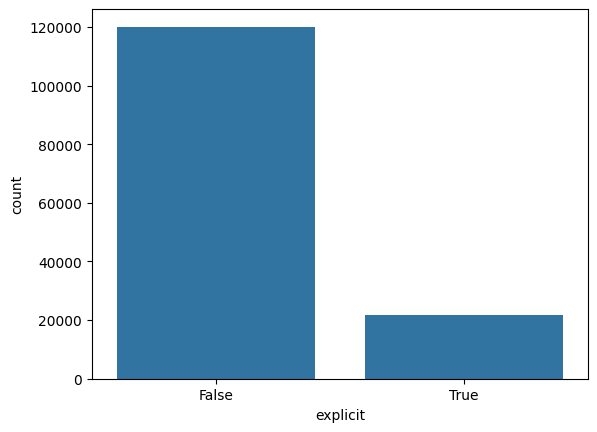

In [ ]:
sns.countplot(x = y)

<div dir=rtl>

##running models after balancing

In [ ]:
edf_down = edf.copy()

In [ ]:
down_true = edf_down[edf_down['explicit'] == True]
down_false = edf_down[edf_down['explicit'] == False]

df_down = down_false.sample(n=len(down_true), random_state=42)
edf_down = pd.concat([down_true, df_down])

X_down, y_down = edf_down.drop(columns = "explicit"), edf_down["explicit"]
edf_down.head(5)

year  artist_id  danceability       key  loudness  speechiness  \
1   1.000000   0.749102      0.654204  0.454545  0.815387     0.294453   
3   1.000000   0.666581      0.629349  0.727273  0.866936     0.148914   
4   0.857143   0.572687      0.810893  0.636364  0.869635     0.035225   
5   1.000000   0.754361      0.595850  1.000000  0.795353     0.005906   
18  0.857143   0.798914      0.712557  1.000000  0.738846     0.026049   

    acousticness  instrumentalness  liveness  valence     tempo  duration_ms  \
1       0.098996          0.000001  0.334433    0.338 -1.210764    -0.807343   
3       0.016667          0.000000  0.093039    0.641  0.380987    -0.641439   
4       0.046185          0.000000  0.200716    0.624 -0.706451     0.665495   
5       0.577309          0.295000  0.106209    0.591  0.045289    -1.269417   
18      0.303213          0.942000  0.141398    0.424  1.460194    -0.163537   

    num_beats  explicit  
1           2      True  
3           2      True  
4           2      True  
5           2      True  
18          2      True

In [ ]:
kf = KFold(n_splits=5, random_state=8, shuffle=True)
scoring_method = "accuracy", "recall", "precision"
X_train, X_test, y_train, y_test = train_test_split(X_down, y_down, test_size = 0.2 , random_state = 8)

In [ ]:
#knn
knn = KNeighborsClassifier(n_neighbors=5)

cv_results = cross_validate(estimator = knn, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  0.077228    1.285443       0.792807     0.828309        0.772837
1  0.068597    1.530342       0.798109     0.816112        0.789807
2  0.100592    2.155022       0.787935     0.814021        0.770285
3  0.093047    2.127651       0.784926     0.817229        0.771123
4  0.071865    1.268766       0.787905     0.822096        0.773042

In [ ]:
#decision tree
tr = DecisionTreeClassifier(random_state=42)

cv_results = cross_validate(estimator = tr, X = X_train, y = y_train, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  0.594850    0.014646       0.783493     0.796153        0.775881
1  0.631013    0.016408       0.775899     0.775690        0.778349
2  0.643239    0.015887       0.776616     0.776072        0.773160
3  0.609801    0.014090       0.766872     0.773024        0.767586
4  0.628227    0.014176       0.782173     0.784703        0.784703

using KNN and random forest

In [ ]:
X, y = edf.drop(columns = "explicit"), edf["explicit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_up, y_up = smote.fit_resample(X_train, y_train)
y_up.count()

192246

In [ ]:
kf = KFold(n_splits=5, random_state=8, shuffle=True)
scoring_method = "accuracy", "recall", "precision"

In [ ]:
#knn
knn = KNeighborsClassifier(n_neighbors=5)

cv_results = cross_validate(estimator = knn, X = X_up, y = y_up, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  0.617511   30.262804       0.885878     0.987001        0.821021
1  0.663797   29.748067       0.889750     0.988389        0.824011
2  0.788874   31.671112       0.893469     0.987451        0.832289
3  1.046271   31.328018       0.891389     0.986787        0.828674
4  0.606153   29.875698       0.888242     0.986455        0.824857

In [ ]:
#decision tree
tr = DecisionTreeClassifier(random_state=42)

cv_results = cross_validate(estimator = tr, X = X_up, y = y_up, cv = kf, scoring=scoring_method)
pd.DataFrame(cv_results)

fit_time  score_time  test_accuracy  test_recall  test_precision
0  4.851061    0.038002       0.884343     0.893355        0.877611
1  5.839469    0.061445       0.883846     0.892403        0.875387
2  5.414520    0.039035       0.886421     0.891241        0.884164
3  4.815969    0.040189       0.884496     0.894975        0.876599
4  6.088907    0.056012       0.886109     0.898230        0.877421

<div dir=rtl>

#checking diffrent models

<div dir=rtl>

## NCC

accuracy: 0.6780234070221066
precision: 0.6648426150121065
recall: 0.7154992703773192


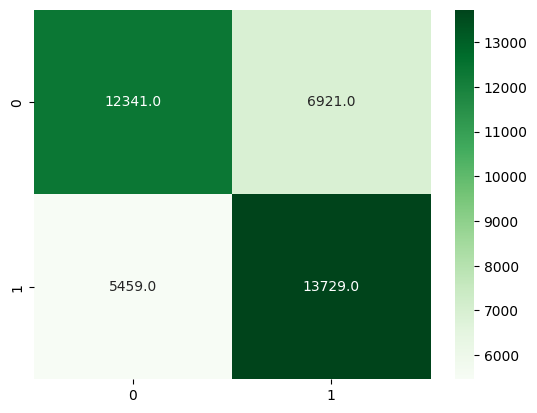

In [ ]:
from sklearn.neighbors import NearestCentroid

X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.2)
ncc = NearestCentroid()
ncc.fit(X_train, y_train)

ncc_pred = ncc.predict(X_test)


print("accuracy:",  accuracy_score(ncc_pred, y_test))
print("precision:", precision_score(y_test, ncc_pred, average="binary"))
print("recall:", recall_score(y_test, ncc_pred, average="binary"))

cm = confusion_matrix(y_test, ncc_pred)
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Greens")
plt.show()

<div dir=rtl>

## grid_search

<div dir=rtl>

### grid_search  - Decision Tree

In [ ]:
param = {"max_depth": range(2, 20)}
clf = GridSearchCV(DecisionTreeClassifier(), param, cv=5, scoring='recall')
clf.fit(X_up, y_up)
pred = clf.predict(X_test)

print("best depth:", clf.best_params_['max_depth'])
print("best recall score:", clf.best_score_)

best depth: 17
best recall score: 0.9213722265243867


<div dir=rtl>

### grid_search  - KNN

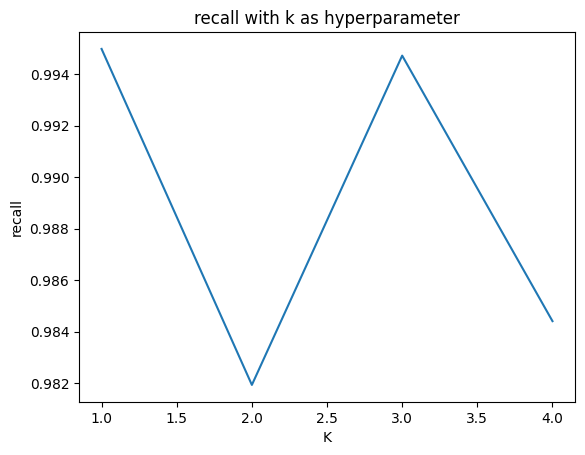

best k value: 1
best recall score: 0.9949752265671379


In [ ]:
param = {"n_neighbors": range(1, 5)}

knn = GridSearchCV(KNeighborsClassifier(), param, cv=5, scoring='recall')
knn.fit(X_up, y_up)

knn_pred = knn.predict(X_test)
knn_rec = recall_score(y_test, knn_pred, average="binary")
results = pd.DataFrame(knn.cv_results_)

sns.lineplot(x=range(1, 5), y=results["mean_test_score"])
plt.title('recall with k as hyperparameter')
plt.xlabel('K')
plt.ylabel('recall')
plt.show()

print("best k value:", knn.best_params_['n_neighbors'])
print("best recall score:", knn.best_score_)

<div dir=rtl>

### grid_search  - Random Forest

In [ ]:
forest = {"n_estimators": range(1, 20)}
rf = GridSearchCV(RandomForestClassifier(), forest, cv=5, scoring='recall')
rf.fit(X_up, y_up)

rf_pred = rf.predict(X_test)

print("best n_estimators value:", rf.best_params_['n_estimators'])
print("recall score:", rf.best_score_)

best n_estimators value: 19
recall score: 0.9328263998134105


<div dir=rtl>

## BaggingClassifier

<div dir=rtl>

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
bagging_score = {}

for i in range(1, 52, 10):
    bagging = BaggingClassifier(estimator =dt, n_estimators=i, random_state=42)
    bagging.fit(X_up, y_up)

    pred = bagging.predict(X_test)
    lst = [accuracy_score(y_test, pred), precision_score(y_test, pred, average='binary'), recall_score(y_test, pred, average='binary')]
    bagging_score[i] = lst

In [ ]:
bagging_score = pd.DataFrame(bagging_score, index=['accuracy', 'precision', 'recall'])
bagging_score

1         11        21        31        41        51
accuracy   0.954356  0.996775  0.998362  0.999142  0.999610  0.999818
precision  0.950535  0.996976  0.998488  0.999010  0.999583  0.999844
recall     0.958412  0.996560  0.998228  0.999270  0.999635  0.999792

<div dir=rtl>

### KNN

In [ ]:
knn = KNeighborsClassifier()
bagging_score = {}

for i in range(1, 52, 10):
    bagging = BaggingClassifier(estimator = knn, n_estimators=i, random_state=42)
    bagging.fit(X_up, y_up)

    pred = bagging.predict(X_test)
    lst = [accuracy_score(y_test, pred), precision_score(y_test, pred, average='binary'), recall_score(y_test, pred, average='binary')]
    bagging_score[i] = lst

In [ ]:
bagging_score = pd.DataFrame(bagging_score, index=['accuracy', 'precision', 'recall'])
bagging_score

1         11        21        31        41        51
accuracy   0.919090  0.928843  0.928192  0.928114  0.928218  0.927958
precision  0.867609  0.877201  0.875956  0.875766  0.875927  0.875526
recall     0.988743  0.996977  0.997342  0.997446  0.997446  0.997446

In [ ]:
forest = RandomForestClassifier()
bagging_score = {}

for i in range(1, 51, 10):
    bagging = BaggingClassifier(estimator = forest, n_estimators=i, random_state=42)
    bagging.fit(X_up, y_up)

    pred = bagging.predict(X_test)
    lst = [accuracy_score(y_test, pred), precision_score(y_test, pred, average='binary'), recall_score(y_test, pred, average='binary')]
    bagging_score[i] = lst

In [ ]:
bagging_score = pd.DataFrame(bagging_score, index=['accuracy', 'precision', 'recall'])
bagging_score

1         11        21        31        41
accuracy   0.972250  0.986294  0.987698  0.987854  0.987776
precision  0.968170  0.981574  0.982619  0.983123  0.982373
recall     0.976496  0.991140  0.992912  0.992704  0.993329

<div dir=rtl>

#clustring - checking data distribution

using a smaller version of the dataframe

In [ ]:
file_id = '1LKYuNkkby7fvLnxBmfeRnnBVsoXNdJPe'
url = f"https://drive.google.com/uc?id={file_id}"
path = '/content/drive/MyDrive/מגשימים/שנה ב/שיעור 13 - אבן דרך/קבצי נתונים/Cluster_file.csv'
data_cluster = pd.read_csv(path, encoding='iso-8859-1')
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   track_name          952 non-null    object
 1   streams             952 non-null    int64 
 2   bpm                 952 non-null    int64 
 3   danceability_%      952 non-null    int64 
 4   valence_%           952 non-null    int64 
 5   energy_%            952 non-null    int64 
 6   acousticness_%      952 non-null    int64 
 7   instrumentalness_%  952 non-null    int64 
 8   liveness_%          952 non-null    int64 
 9   speechiness_%       952 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 74.5+ KB


In [ ]:
df = data_cluster.drop(columns = "track_name")

mms = MinMaxScaler()
for i in df.columns:
  df[i] = mms.fit_transform(df[[i]])

data_cluster.head()

track_name    streams  bpm  danceability_%  \
0  Seven (feat. Latto) (Explicit Ver.)  141381703  125              80   
1                                 LALA  133716286   92              71   
2                              vampire  140003974  138              51   
3                         Cruel Summer  800840817  170              55   
4                       WHERE SHE GOES  303236322  144              65   

   valence_%  energy_%  acousticness_%  instrumentalness_%  liveness_%  \
0         89        83              31                   0           8   
1         61        74               7                   0          10   
2         32        53              17                   0          31   
3         58        72              11                   0          11   
4         23        80              14                  63          11   

   speechiness_%  
0              4  
1              4  
2              6  
3             15  
4              6

<Axes: >

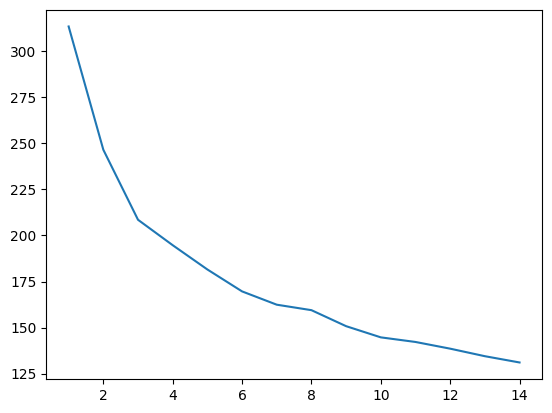

In [ ]:
import sklearn.cluster as skl_cluster

lst = []

for i in range(1,15):
  model = skl_cluster.KMeans(n_clusters=i, random_state=1, n_init='auto')
  model.fit(df)
  clusters= model.predict (df)
  lst.append(model.inertia_)

sns.lineplot(x=range(1,15), y=lst)

In [ ]:
kmeans = KMeans(n_clusters = 6)

kmeans.fit(df)
kmeans_pred = kmeans.predict(df)

df["cluster"] = kmeans_pred
data_cluster["cluster"] = kmeans_pred
data_cluster.head()

track_name    streams  bpm  danceability_%  \
0  Seven (feat. Latto) (Explicit Ver.)  141381703  125              80   
1                                 LALA  133716286   92              71   
2                              vampire  140003974  138              51   
3                         Cruel Summer  800840817  170              55   
4                       WHERE SHE GOES  303236322  144              65   

   valence_%  energy_%  acousticness_%  instrumentalness_%  liveness_%  \
0         89        83              31                   0           8   
1         61        74               7                   0          10   
2         32        53              17                   0          31   
3         58        72              11                   0          11   
4         23        80              14                  63          11   

   speechiness_%  cluster  
0              4        0  
1              4        0  
2              6        2  
3             15        2  
4              6        2

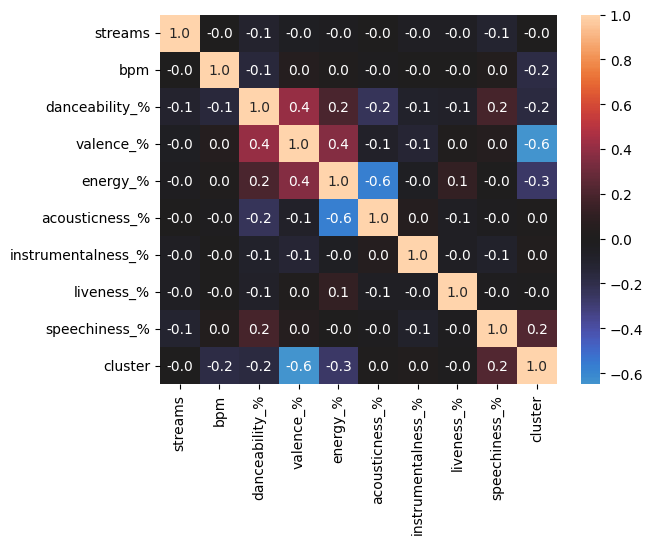

In [ ]:
cor = df.corr()

sns.heatmap(cor, annot=True, fmt=".1f", center=0)
plt.show()

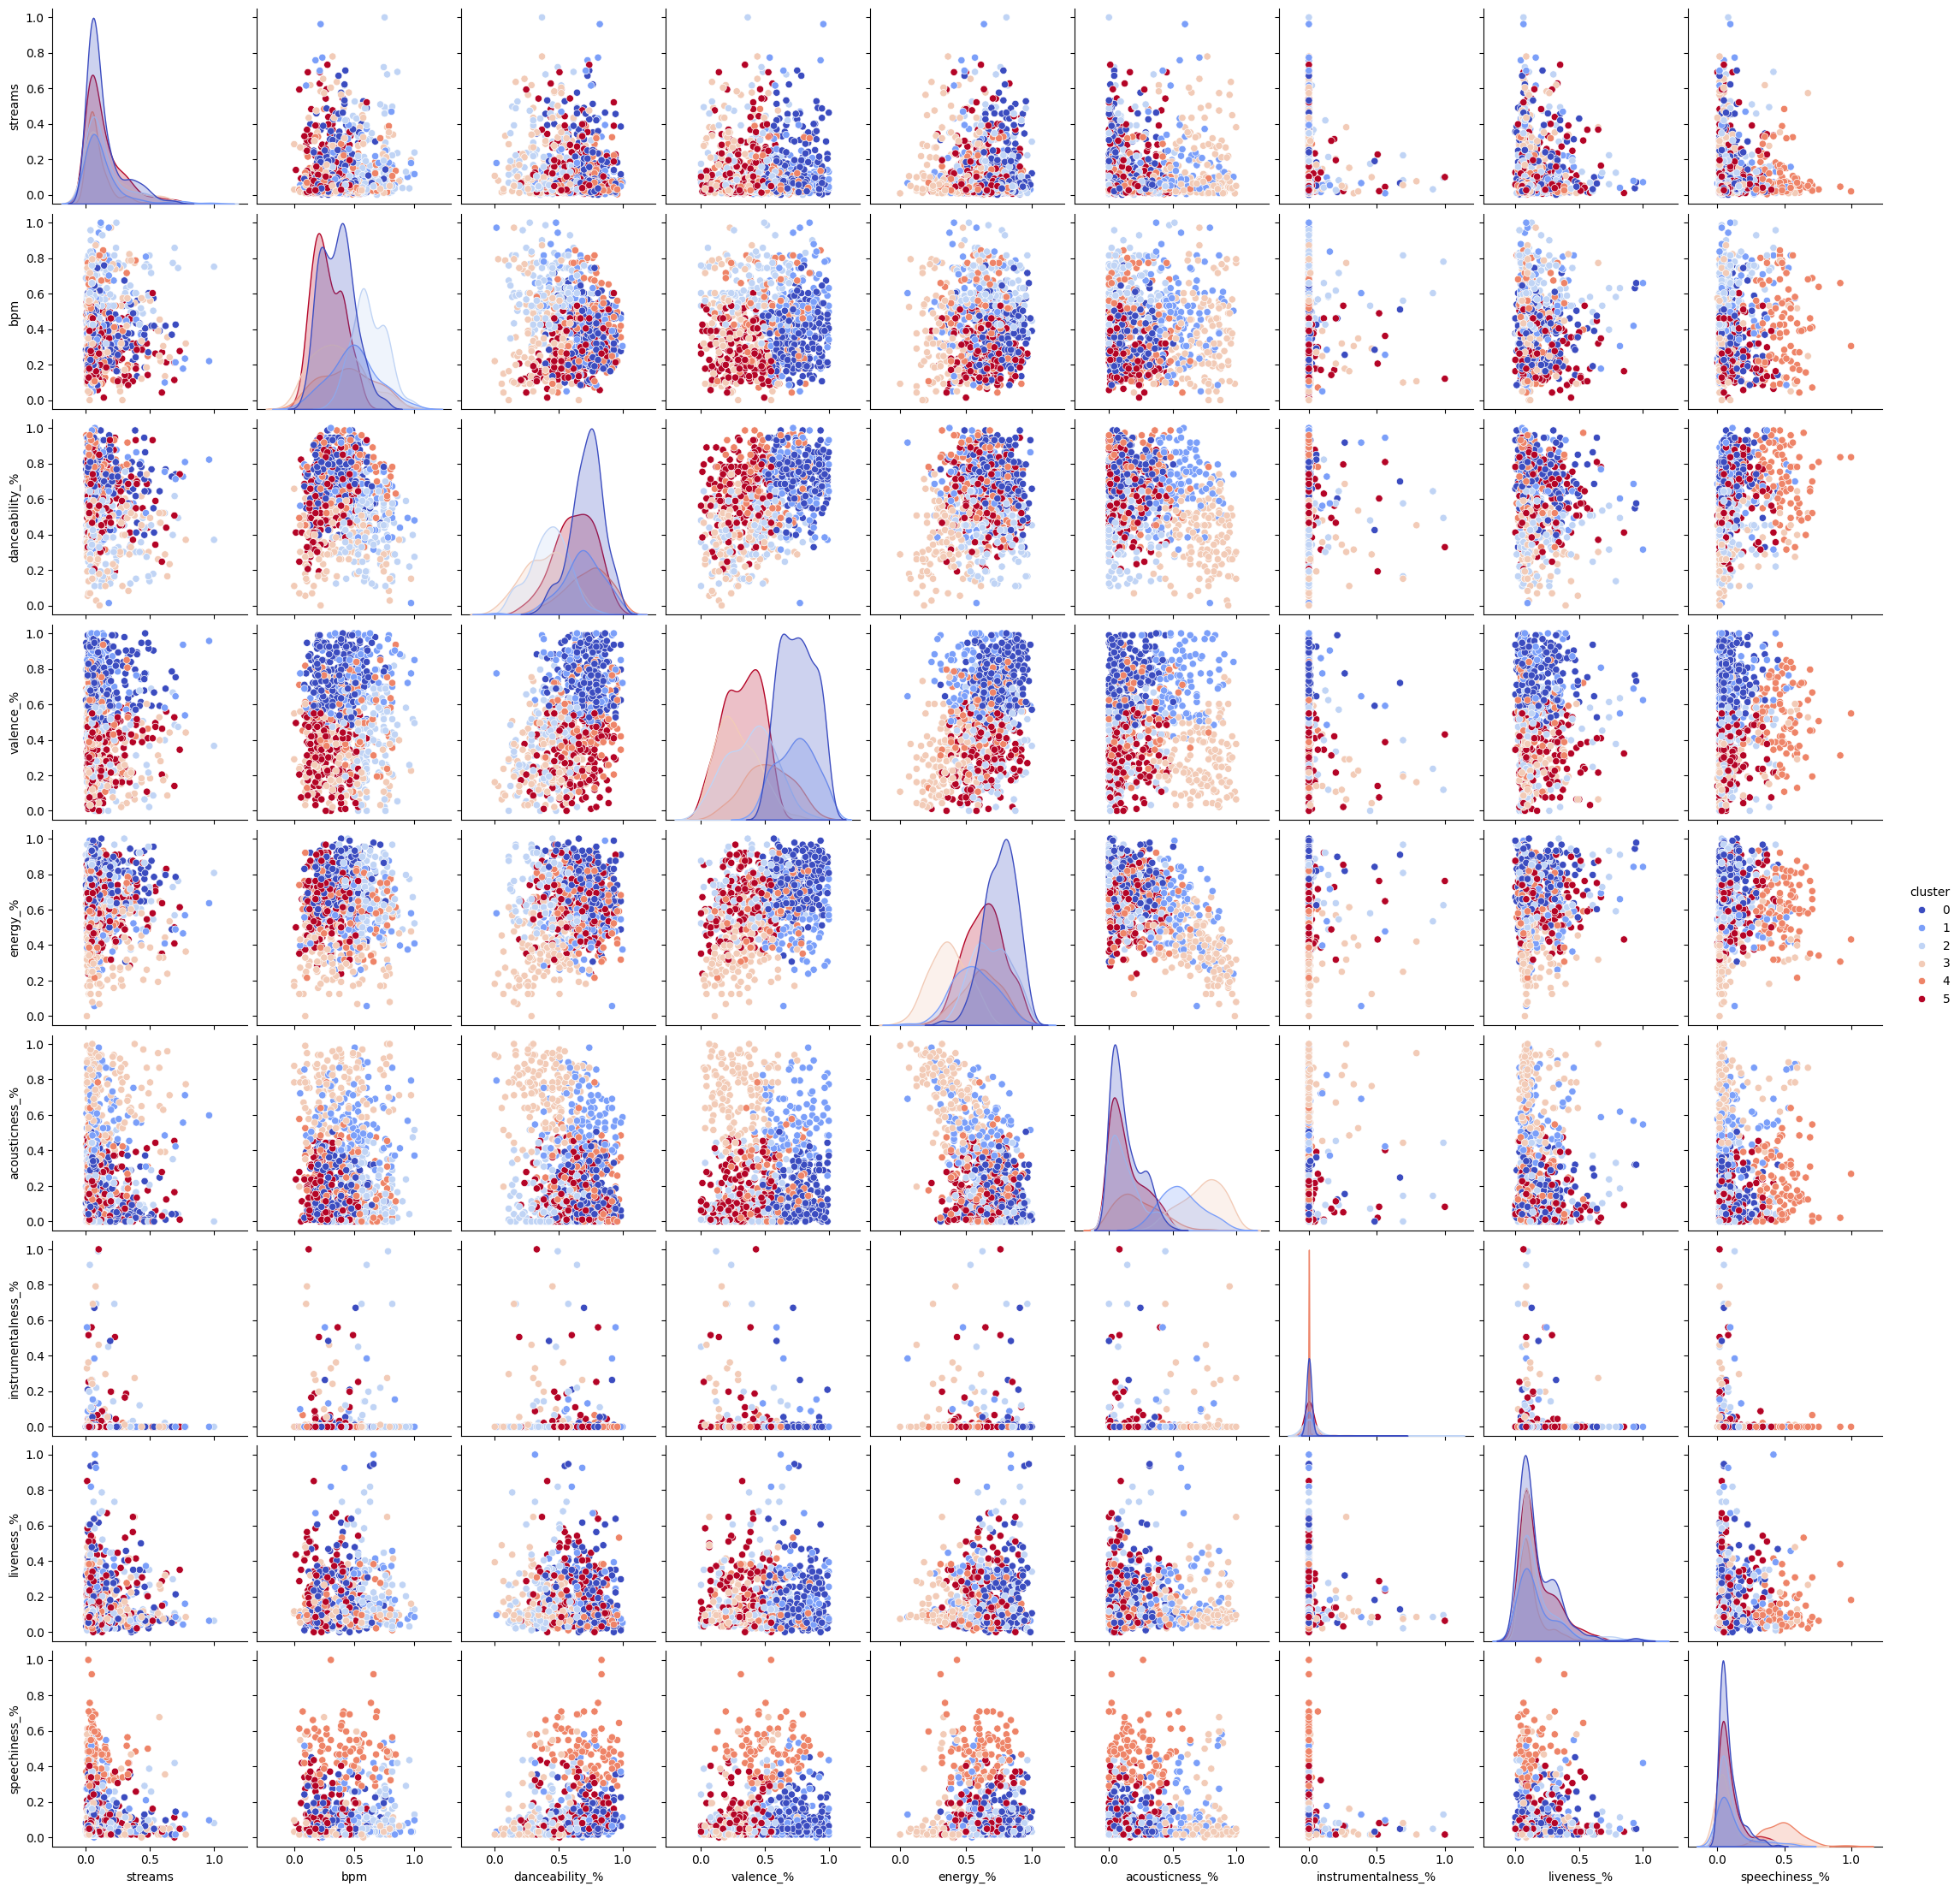

In [ ]:
sns.pairplot(df, hue="cluster", palette="coolwarm")

<p dir="rtl"><b><u> דוגמה לקבוצה 0: </b></u></p>


In [ ]:
data_cluster[data_cluster["cluster"] == 0].head()

track_name     streams  bpm  danceability_%  \
0   Seven (feat. Latto) (Explicit Ver.)   141381703  125              80   
1                                  LALA   133716286   92              71   
11                            Super Shy    58255150  150              78   
12                              Flowers  1316855716  118              71   
18                           Classy 101   335222234  100              86   

    valence_%  energy_%  acousticness_%  instrumentalness_%  liveness_%  \
0          89        83              31                   0           8   
1          61        74               7                   0          10   
11         52        82              18                   0          15   
12         65        68               6                   0           3   
18         67        66              14                   0          12   

    speechiness_%  cluster  
0               4        0  
1               4        0  
11              7        0  
12              7        0  
18             16        0

<p dir="rtl"><b><u> דוגמה לקבוצה 1: </b></u></p>


In [ ]:
data_cluster[data_cluster["cluster"] == 1].head()

track_name     streams  bpm  \
6                                    Ella Baila Sola   725980112  148   
16                                 Cupid - Twin Ver.   496795686  120   
34                                               TQG   618990393  180   
41     Sunflower - Spider-Man: Into the Spider-Verse  2808096550   90   
44  Barbie World (with Aqua) [From Barbie The Album]    65156199  144   

    danceability_%  valence_%  energy_%  acousticness_%  instrumentalness_%  \
6               67         83        76              48                   0   
16              78         76        59              43                   0   
34              72         61        63              67                   0   
41              76         91        50              54                   0   
44              77         75        58              52                   0   

    liveness_%  speechiness_%  cluster  
6            8              3        1  
16          34              3        1  
34           9             28        1  
41           7              5        1  
44          23             25        1

<p dir="rtl"><b><u> דוגמה לקבוצה 2: </b></u></p>


In [ ]:
data_cluster[data_cluster["cluster"] == 2].head()

track_name     streams  bpm  danceability_%  valence_%  energy_%  \
2            vampire   140003974  138              51         32        53   
3       Cruel Summer   800840817  170              55         58        72   
4     WHERE SHE GOES   303236322  144              65         23        80   
14         As It Was  2513188493  174              52         66        73   
22  I Wanna Be Yours  1297026226  135              48         44        42   

    acousticness_%  instrumentalness_%  liveness_%  speechiness_%  cluster  
2               17                   0          31              6        2  
3               11                   0          11             15        2  
4               14                  63          11              6        2  
14              34                   0          31              6        2  
22              12                   2          11              3        2

In [ ]:
data_cluster[data_cluster["cluster"] == 3].head()

track_name     streams  bpm  \
13                                           Daylight   387570742  130   
17  What Was I Made For? [From The Motion Picture ...    30546883   78   
54                                       Another Love  1813673666  123   
72                                        golden hour   751134527   94   
76                                       Here With Me   635412045  132   

    danceability_%  valence_%  energy_%  acousticness_%  instrumentalness_%  \
13              51         32        43              83                   0   
17              44         14         9              96                   0   
54              45         13        54              70                   0   
72              51         14        59              65                  18   
76              58         27        48              50                   0   

    liveness_%  speechiness_%  cluster  
13           9              3        3  
17          10              3        3  
54           9              4        3  
72          25              3        3  
76          12              3        3

In [ ]:
data_cluster[data_cluster["cluster"] == 4].head()

track_name     streams  bpm  danceability_%  valence_%  \
5                       Sprinter   183706234  141              92         66   
9                La Bebe - Remix   553634067  170              81         56   
64                       Hey Mor   674072710   98              90         40   
95   All My Life (feat. J. Cole)   144565150  143              83         69   
115               No Role Modelz  1791000570  100              70         47   

     energy_%  acousticness_%  instrumentalness_%  liveness_%  speechiness_%  \
5          58              19                   0           8             24   
9          48              21                   0           8             33   
64         59               0                   0          10             29   
95         44              15                   0          10             33   
115        52              30                   0           6             33   

     cluster  
5          4  
9          4  
64         4  
95         4  
115        4

In [ ]:
data_cluster[data_cluster["cluster"] == 5].head()

track_name     streams  bpm  danceability_%  valence_%  energy_%  \
7     Columbia    58149378  100              67         26        71   
8     fukumean    95217315  130              85         22        62   
10   un x100to   505671438   83              57         56        72   
15   Kill Bill  1163093654   89              64         43        73   
19  Like Crazy   363369738  120              63         36        73   

    acousticness_%  instrumentalness_%  liveness_%  speechiness_%  cluster  
7               37                   0          11              4        5  
8               12                   0          28              9        5  
10              23                   0          27              5        5  
15               5                  17          16              4        5  
19               0                   0          36              4        5